## Goal
- Implement classification with resnet18 in tinyImagenet dataset using d2l library
    - Wrap tiny imagenet data under d2l library
    - Fit with GPU
    - Record validation losses, accuracy, time taken to train

In [1]:
import torch
import time
import d2l.torch as d2l
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
from torchvision.transforms import transforms
from torchvision.models import resnet18
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset, Image
import json
import requests
from data import TinyImagenetD2l
import collections
from IPython import display

In [2]:
batch_size = 256
num_workers = 2
learning_rate = 0.01
num_epochs = 2
device = d2l.try_gpu()
device

device(type='cuda', index=0)

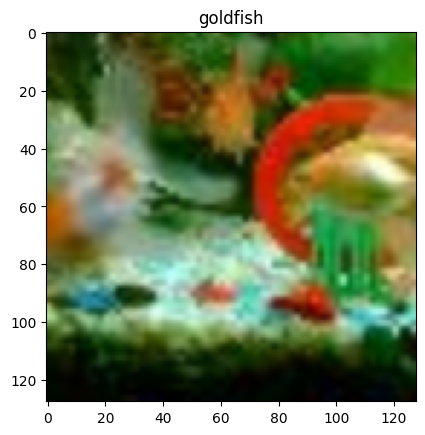

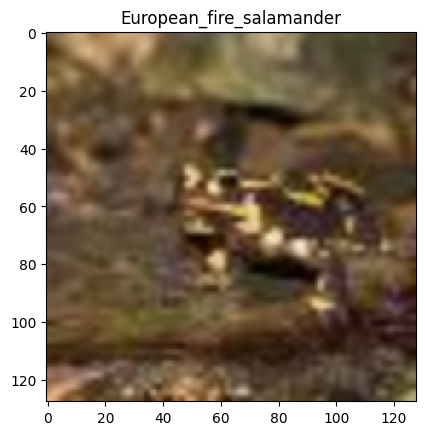

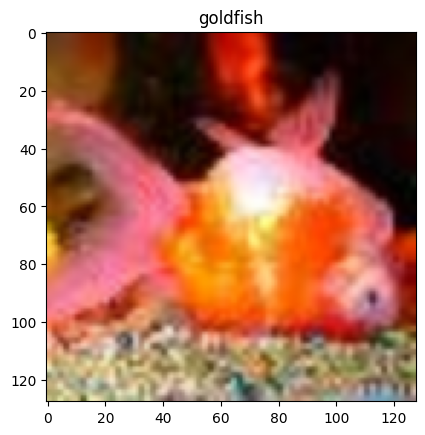

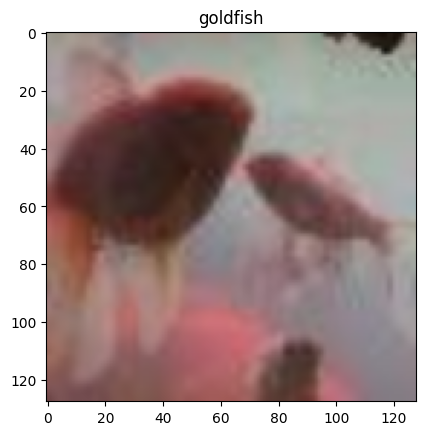

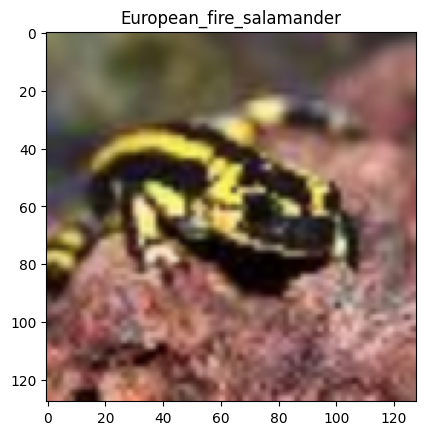

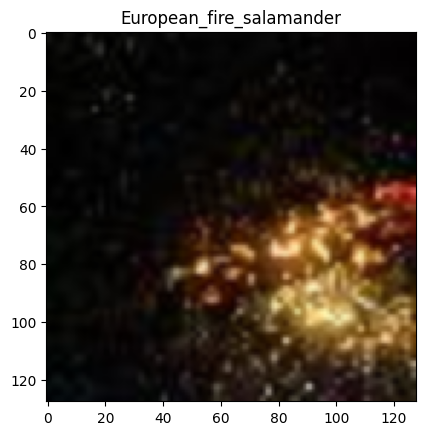

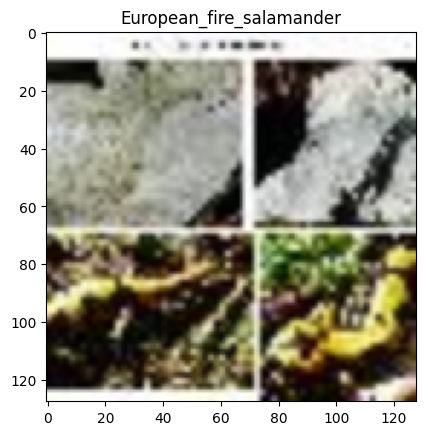

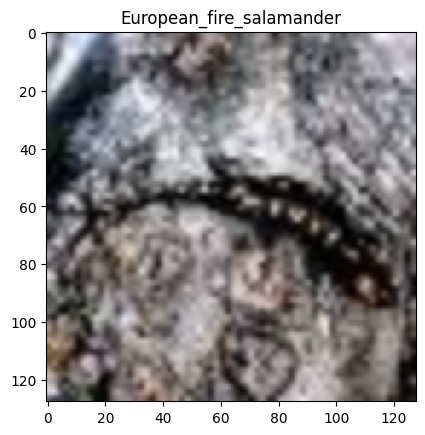

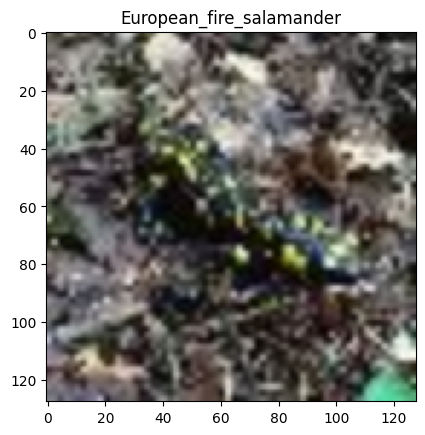

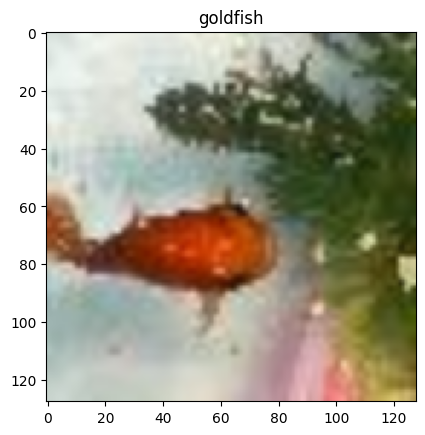

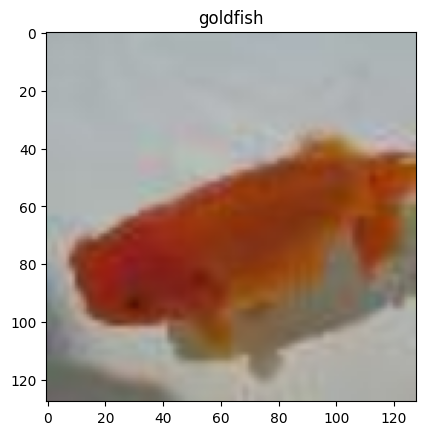

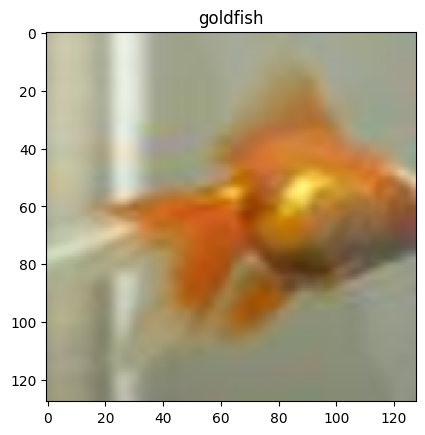

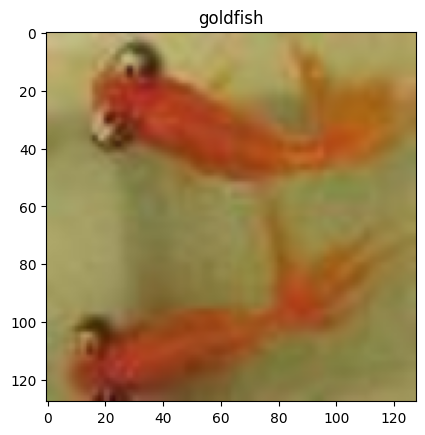

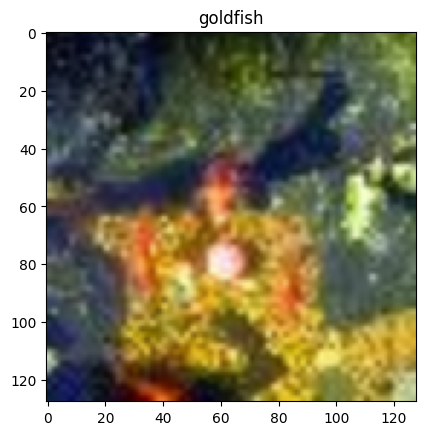

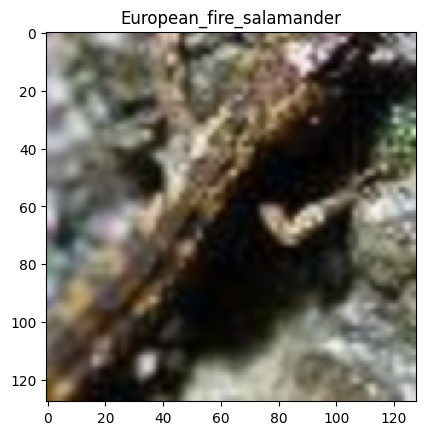

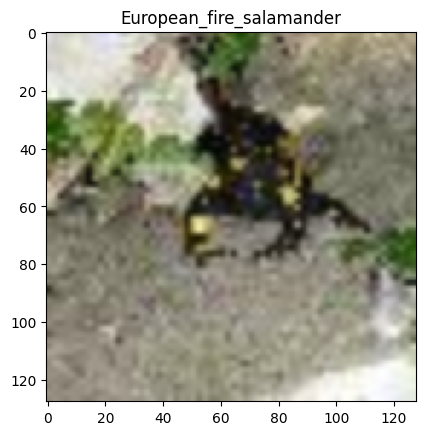

In [3]:
tiny_imagenet = TinyImagenetD2l(batch_size, num_workers, is_toy=True)
train_loader = tiny_imagenet.get_dataloader(train=True)
val_loader = tiny_imagenet.get_dataloader(train=False)

tiny_imagenet.visualize(next(iter(train_loader)))


In [4]:
from collections import defaultdict

class ResnetD2l(d2l.Classifier):
    def __init__(self, num_classes, pretrained=False, lr=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.net = resnet18(pretrained=pretrained)
        self.net.fc = nn.Linear(512, num_classes)
        self.board = d2l.ProgressBoard()
        metric_object = {"train" : [], "val" : [], "figure" : None} 
        self.metrics = defaultdict(lambda : metric_object)
        self.figsize = (10, 5)

        def init_weights(m):
            if type(m) == nn.Linear or type(m) == nn.Conv2d:
                nn.init.xavier_uniform_(m.weight)
        self.net.apply(init_weights)
    
    def forward(self, x):
        return self.net(x)
    
    def loss(self, y_hat, y):
        return nn.CrossEntropyLoss()(y_hat, y)

In [7]:


@d2l.add_to_class(d2l.Trainer)
def prepare_batch(self, batch):
    x = batch['image']
    y = batch['label']
    return (x.to(self.device), y.to(self.device))

@d2l.add_to_class(d2l.Classifier)
def validation_step(self, batch):
    Y_hat = self(*batch[:-1])
    val_loss = self.loss(Y_hat, batch[-1])
    val_acc = self.accuracy(Y_hat, batch[-1])
    self.metrics['loss']['val'].append(val_loss.item())
    self.metrics['accuracy']['val'].append(val_acc.item())
    self.plot('loss', val_loss, train=False)
    self.plot('accuracy', val_acc, train=False)

@d2l.add_to_class(d2l.Classifier)
def training_step(self, batch):
    l = self.loss(self(*batch[:-1]), batch[-1])
    acc = self.accuracy(self(*batch[:-1]), batch[-1])
    self.metrics['loss']['train'].append(l.item())
    self.metrics['accuracy']['train'].append(acc.item())
    self.plot('loss', l, train=True)
    self.plot('accuracy', acc, train=True)
    return l

@d2l.add_to_class(d2l.Classifier)
def get_running_mean(self, metric, num_batches):
    return np.mean(self.metrics[metric][-num_batches:])

@d2l.add_to_class(d2l.Classifier)
def plot(self, key, value, train):
    """Plot a point in animation."""
    assert hasattr(self, 'trainer'), 'Trainer is not inited'
    self.board.xlabel = 'epoch'
    if train:
        x = self.trainer.train_batch_idx / \
            self.trainer.num_train_batches
        n = self.trainer.num_train_batches / \
            self.plot_train_per_epoch
    else:
        x = self.trainer.epoch + 1
        n = self.trainer.num_val_batches / \
            self.plot_valid_per_epoch
    
    print(key, self.metrics[key]["figure"], train)
    if self.metrics[key]["figure"] is None:
        print("Creating figure", key)
        self.metrics[key]["figure"] = d2l.plt.figure(figsize=self.figsize)

    '''
    self.board.draw(x, d2l.numpy(d2l.to(value, d2l.cpu())),
                    train, key,
                    every_n=int(n), fig = self.metrics[key]["figure"])
    '''

@d2l.add_to_class(d2l.ProgressBoard)
def draw(self, x, y, train, key, every_n=1, fig=None):
    """Defined in :numref:`sec_utils`"""
    Point = collections.namedtuple('Point', ['x', 'y'])
    label = ('train_' if train else 'val_') + key


    if not hasattr(self, 'raw_points'):
        self.raw_points = collections.OrderedDict()
        self.data = collections.OrderedDict()
    if label not in self.raw_points:
        self.raw_points[label] = []
        self.data[label] = []
    points = self.raw_points[label]
    line = self.data[label]
    points.append(Point(x, y))
    if len(points) != every_n:
        return
    mean = lambda x: sum(x) / len(x)
    line.append(Point(mean([p.x for p in points]),
                        mean([p.y for p in points])))
    points.clear()
    if not self.display:
        return
    d2l.use_svg_display()
    if fig is None:
        fig = d2l.plt.figure()
    


    plt_lines, labels = [], []
    for (k, v), ls, color in zip(self.data.items(), self.ls, self.colors):
        if k == key:
            plt_lines.append(d2l.plt.plot([p.x for p in v], [p.y for p in v],
                                        linestyle=ls, color=color)[0])
            labels.append(k)
    axes = self.axes if self.axes else d2l.plt.gca()
    if self.xlim: axes.set_xlim(self.xlim)
    if self.ylim: axes.set_ylim(self.ylim)
    if not self.xlabel: self.xlabel = self.x
    axes.set_xlabel(self.xlabel)
    axes.set_ylabel(self.ylabel)
    axes.set_xscale(self.xscale)
    axes.set_yscale(self.yscale)
    axes.legend(plt_lines, labels)
    display.display(fig)
    display.clear_output(wait=True)

In [8]:

data = TinyImagenetD2l(batch_size, num_workers, is_toy=True)
num_training_batches = len(data.train_data)
num_val_batches = len(data.val_data)
model = ResnetD2l(num_classes=data.num_classes, pretrained=False, lr=learning_rate)
model.to(device)

trainer = d2l.Trainer(max_epochs=num_epochs, num_gpus=1)
trainer.device = device
trainer.fit(model=model, data=data)

train_loss = model.get_running_mean("train_loss", num_training_batches)
val_loss = model.get_running_mean("val_loss", num_val_batches)
val_acc = model.get_running_mean("val_acc", num_val_batches)

print(f"Train loss: {train_loss}, Val loss: {val_loss}, Val acc: {val_acc}")




/home/ajrfhp/anaconda3/envs/GPT2/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ajrfhp/anaconda3/envs/GPT2/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


loss None True
Creating figure loss
accuracy Figure(1000x500) True
loss Figure(1000x500) True
accuracy Figure(1000x500) True
loss Figure(1000x500) True
accuracy Figure(1000x500) True
loss Figure(1000x500) True
accuracy Figure(1000x500) True
loss Figure(1000x500) False
accuracy Figure(1000x500) False
loss Figure(1000x500) True
accuracy Figure(1000x500) True
loss Figure(1000x500) True
accuracy Figure(1000x500) True
loss Figure(1000x500) True
accuracy Figure(1000x500) True
loss Figure(1000x500) True
accuracy Figure(1000x500) True
loss Figure(1000x500) False
accuracy Figure(1000x500) False


TypeError: unhashable type: 'slice'

<Figure size 1000x500 with 0 Axes>

In [ ]:
model = ResnetD2l(num_classes=data.num_classes, pretrained=True, lr=learning_rate)
model.to(device)

trainer = d2l.Trainer(max_epochs=num_epochs, num_gpus=1)
trainer.device = device
trainer.fit(model=model, data=data)

train_loss = model.get_running_mean(num_training_batches)
val_loss = model.get_running_mean(num_val_batches)
val_acc = model.get_running_mean(num_val_batches)

print(f"Train loss: {train_loss}, Val loss: {val_loss}, Val acc: {val_acc}")


